In [ ]:
from skopt.space import Real
from skopt.sampler import Lhs

def adaptive_constrained_lhs(var_bounds, constraint_fn, n_valid=100, batch_size=200, max_attempts=10):
    """
    Generate constrained LHS samples adaptively until n_valid samples are collected.

    Args:
        var_bounds (dict): Variable bounds, e.g., {'P_in': (3, 10), 'P_out': (1, 9)}
        constraint_fn (function): Function that returns True if sample is valid
        n_valid (int): Desired number of valid samples
        batch_size (int): How many samples to generate per batch
        max_attempts (int): Max number of batches to try

    Returns:
        valid_samples (list of dict): Filtered valid samples
    """
    space = [Real(*bounds, name=name) for name, bounds in var_bounds.items()]
    lhs = Lhs(criterion='maximin', iterations=1000)
    var_names = list(var_bounds.keys())
    
    valid_samples = []
    attempts = 0

    while len(valid_samples) < n_valid and attempts < max_attempts:
        raw_samples = lhs.generate(space, batch_size)
        for row in raw_samples:
            sample = dict(zip(var_names, row))
            if constraint_fn(sample):
                valid_samples.append(sample)
                if len(valid_samples) == n_valid:
                    break
        attempts += 1

    if len(valid_samples) < n_valid:
        raise RuntimeError(
            f"Only {len(valid_samples)} valid samples found after {attempts} attempts "
            f"with batch size {batch_size}. Consider relaxing the constraint or increasing max_attempts."
        )

    return valid_samples


def Turb_pres_con(sample):
    return sample['P_out'] < sample['P_in']

def Comp_pres_con(sample):
    return sample['P_out'] > sample['P_in'] 

def Cooler_pres_con(sample):
    return sample['T_out'] < sample['T_in']

def Heater_pres_con(sample):
    return sample['T_out'] > sample['T_in']

def Hex_pres_con(sample):
    return sample['T1_out'] > sample['T1_in'] and sample['T2_out'] < sample['T2_in']

var_bounds = {
    'T_in': (32, 530), 
    'P_in': (74e5, 300e5),
    'M_in':(50,160),
    'P_out':(74e5,300e5)
}

samples = adaptive_constrained_lhs(var_bounds, Turb_pres_con, n_valid=1000, batch_size=200)
print(f"Generated {len(samples)} valid samples.")

In [ ]:
equipment = [0,13,14]
PFD.Flowsheet_Building(equipment) # build the flowsheet with the given equipment
power_output = np.zeros(len(samples)) # initialize the power output array
output_stream_specs = np.zeros((len(samples), 2)) # initialize the output stream specifications array
for (i,sample) in enumerate(samples):
    dv = [0, sample['P_out'],0]
    PFD.stream_dict["IN1"].inlet = [sample['T_in'], sample['P_in'], {"CO2": sample['M_in']}]
    PFD.stream_dict["IN1"].inlet_stream()
    PFD.Flowsheet_Simulation(equipment, dv) # run the simulation with the given decision variables
    PFD.sim.EngineRun()
    T_out, P_out = PFD.stream_dict["Product"].get_temp(), PFD.stream_dict["Product"].get_press()
    power_output[i] = PFD.unit_dict["T1"].enery_consumption()  # Assuming T1 is the turbine
    output_stream_specs[i] = [T_out, P_out]

In [ ]:
#create a DataFrame to store the results
import pandas as pd
results_df = pd.DataFrame({
    'T_in': [sample['T_in'] for sample in samples],
    'P_in': [sample['P_in'] for sample in samples],
    'M_in': [sample['M_in'] for sample in samples],
    'P_out': [sample['P_out'] for sample in samples],
    'Power_Output': power_output,
    'T_out': output_stream_specs[:, 0],
    'P_out': output_stream_specs[:, 1]
})
results_df.to_csv('Turbine_surrogate_data.csv')
len(samples), len(power_output), len(output_stream_specs)

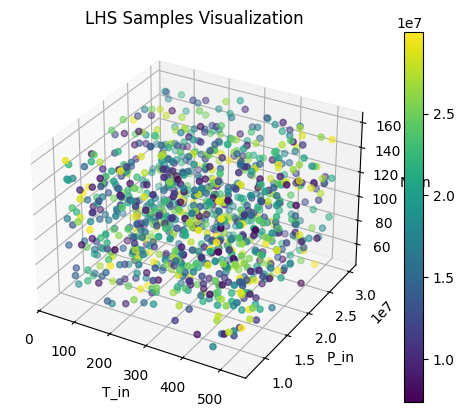

In [16]:
#visualize the samples in 3d and use 4th variable as color
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = [s['T_in'] for s in samples]
y = [s['P_in'] for s in samples]
z = [s['M_in'] for s in samples]
c = [s['P_out'] for s in samples]

sc = ax.scatter(x, y, z, c=c, cmap='viridis')
plt.colorbar(sc)

ax.set_xlabel('T_in')
ax.set_ylabel('P_in')
ax.set_zlabel('M_in')
plt.title('LHS Samples Visualization')
plt.show()